# 1. Problem

### Analyzing Shakespeare's Works for Text Generation

The goal of this project is to develop a deep learning model (RNN) that can generate text resembling the style and language of [William Shakespeare](https://en.wikipedia.org/wiki/William_Shakespeare
).  The model will learn from a corpus of Shakespeare's plays to capture his unique vocabulary, syntax, and poetic patterns.

## About the Dataset

This dataset is a collection of all shakepeare's plays, characters, lines, and acts.

[LEARN MORE](https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays)

### Features

1. **Data-Line:** it  keeps track of all the rows there are i.e the serial number
2. **Play:** the play that the lines are from.
3. **PlayLinenumber:** the actual line being spoken at any given time.
4. **ActSceneLine:** the Act-Scene-Line from which any given line is from.
5. **Player:** the player who is saying any given line.
6. **PlayerLine:** the line being spoken.





## Import Libraries

In [ ]:
! pip install pandas
! pip install kaggle
! pip install seaborn
! pip install wordcloud
! pip install nltk
! pip install tensorflow keras keras-preprocessing
! pip install gensim
! pip install scikit-learn
! pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout
from kerastuner import HyperParameters

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

<ipython-input-2-a27b8eb36ec2>:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Load dataset

Visit [here](https://www.kaggle.com/discussions/general/74235) to learn how to download data from Kaggle to google colab

In [ ]:
# uncomment if you're using google colab
from google.colab import drive
drive.mount('/content/drive')

ValueError: The domain policy has disabled Drive File Stream: https://support.google.com/a/answer/7496409

In [ ]:
# upload kaggle credentials
from google.colab import files # uncomment if you're using google colab
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle

In [ ]:
# copy kaggle.json to .kaggle
! cp ./kaggle.json ~/.kaggle

In [ ]:
# change permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# check if everything works well
! kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
prasad22/vehicle-population-statistics                     Vehicle Population Statistics                       44KB  2024-05-25 03:31:34            742         24  1.0              
rohit265/credit-card-eligibility-data-determining-factors  Credit Card Eligibility Data: Determining Factors  296KB  2024-05-18 11:31:28            954         23  1.0              
rahulvyasm/netflix-movies-and-tv-shows                     Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          25677        549  1.0              
mayankanand2701/netflix-stock-price-dataset                Netflix Stock Price Dataset 🎥🍿🎬

In [ ]:
# download dataset
! kaggle datasets download -d kingburrito666/shakespeare-plays

Dataset URL: https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays
License(s): unknown
 88% 4.00M/4.55M [00:01<00:00, 4.52MB/s]
100% 4.55M/4.55M [00:01<00:00, 3.66MB/s]


In [ ]:
! mkdir shakespeare-plays

In [ ]:
# unzip data
! unzip shakespeare-plays.zip -d shakespeare-plays

Archive:  shakespeare-plays.zip
  inflating: shakespeare-plays/Shakespeare_data.csv  
  inflating: shakespeare-plays/alllines.txt  
  inflating: shakespeare-plays/william-shakespeare-black-silhouette.jpg  


In [ ]:
# Load the dataset
data_file = "shakespeare-plays/Shakespeare_data.csv"
data = pd.read_csv(data_file)

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [ ]:
df = data.copy()

**Print data shape**


In [ ]:
df.shape

(111396, 6)

In [ ]:
df.head(5)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [ ]:
df.tail(5)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
111391,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first
111394,111395,A Winters Tale,38.0,5.3.183,LEONTES,We were dissever'd: hastily lead away.
111395,111396,A Winters Tale,38.0,NaN,LEONTES,Exeunt


**Print datatypes of dataset**

In [ ]:
df.dtypes

Dataline              int64
Play                 object
PlayerLinenumber    float64
ActSceneLine         object
Player               object
PlayerLine           object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Dataline          111396 non-null  int64  
 1   Play              111396 non-null  object 
 2   PlayerLinenumber  111393 non-null  float64
 3   ActSceneLine      105153 non-null  object 
 4   Player            111389 non-null  object 
 5   PlayerLine        111396 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [ ]:
df.describe()

,Dataline,PlayerLinenumber
count,111396.000000,111393.000000
mean,55698.500000,36.885334
std,32157.399631,39.985840
min,1.000000,1.000000
25%,27849.750000,10.000000
50%,55698.500000,25.000000
75%,83547.250000,50.000000
max,111396.000000,405.000000


### Data Cleaning & Preprocessing

**Missing (null) Values**

In [ ]:
# count NaN
df.isna().sum()

Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

**Drop unneccessary features**

These are features that do not provide relevant information to the problem. Since the focus is to train our model in text generations based on play lines, and the **Playerline** column provides these data, therefore, we only keep this column.

In [ ]:
dropped_features = ['Dataline', 'Play', 'PlayerLinenumber', 'ActSceneLine', 'Player']

In [ ]:
df.drop(dropped_features, axis=1, inplace=True)

In [ ]:
df.head(5)

,PlayerLine
0,ACT I
1,SCENE I. London. The palace.
2,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,"So shaken as we are, so wan with care,"
4,"Find we a time for frighted peace to pant,"


### Text Analysis

**Word Counts**

In [ ]:
df['word_count'] = df['PlayerLine'].apply(lambda x: len(str(x).split()))
df['word_count'].describe()

count    111396.000000
mean          7.313288
std           2.635567
min           1.000000
25%           6.000000
50%           8.000000
75%           9.000000
max         163.000000
Name: word_count, dtype: float64

**Character Counts**

In [ ]:
df['char_count'] = df['PlayerLine'].apply(lambda x: len(str(x)))
df['char_count'].describe()

count    111396.000000
mean         38.196093
std          13.407790
min           1.000000
25%          34.000000
50%          41.000000
75%          46.000000
max        1029.000000
Name: char_count, dtype: float64

**Common Words**

In [ ]:
# Combine all tweet texts into a single string
all_text = ' '.join(df['PlayerLine'].astype(str))

# Count the frequency of each word
word_counts = Counter(all_text.split())

# Get the most common words
most_common_words = word_counts.most_common(20)  # Top 20 words
most_common_words

[('the', 23285),
 ('I', 18972),
 ('and', 17698),
 ('to', 15011),
 ('of', 14666),
 ('a', 12129),
 ('my', 10329),
 ('in', 9199),
 ('you', 8812),
 ('is', 7595),
 ('that', 7188),
 ('not', 6697),
 ('And', 6552),
 ('with', 6410),
 ('his', 5938),
 ('your', 5892),
 ('be', 5834),
 ('for', 5509),
 ('have', 5137),
 ('it', 4807)]

**Word Cloud**

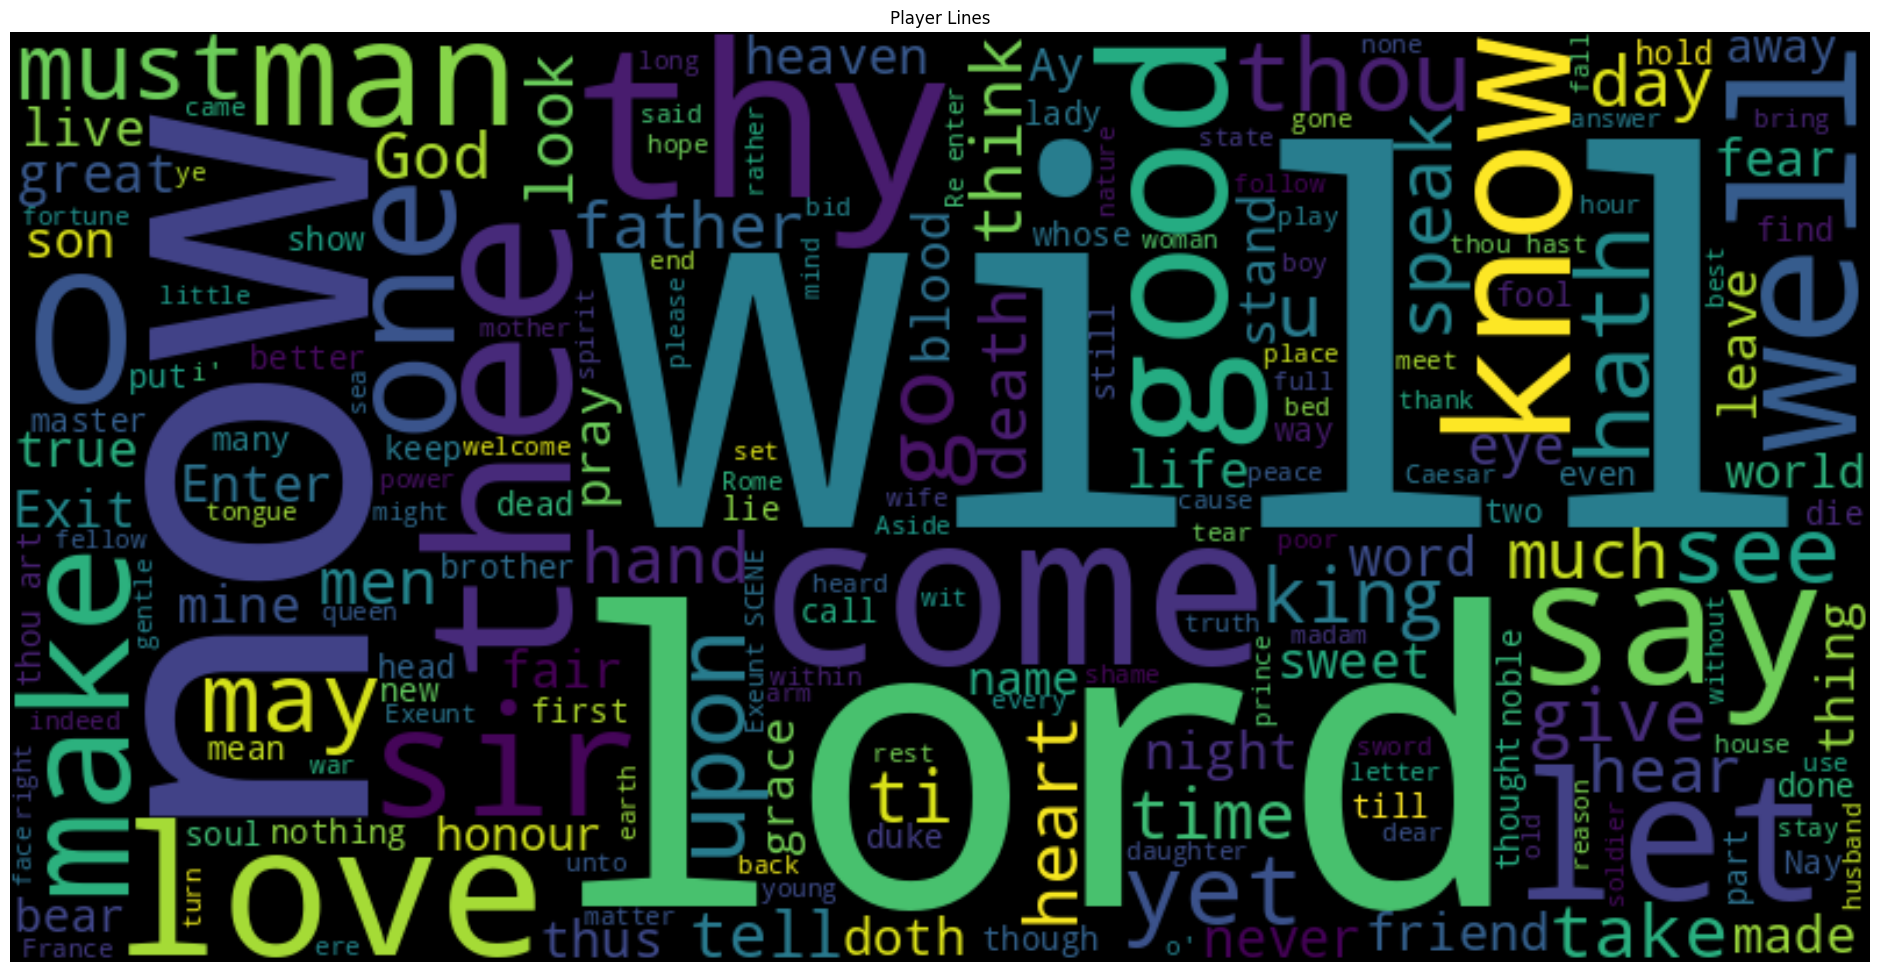

In [ ]:
wc = WordCloud(width=800, height=400).generate(all_text)

plt.figure(figsize=(24, 24))
plt.imshow(wc, interpolation='bilinear')
plt.title('Player Lines')
plt.axis('off')

plt.show()

### Preprocessing

For our proprocessing steps we will

1. Lowercase
2. Tokenize text
3. Apply lemmitization

In [ ]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase and remove URLs and HTML tags
    text = re.sub(r"http\S+", "", text.lower())
    text = re.sub(r"<.*?>", "", text)

    # Tokenize
    words = nltk.word_tokenize(text)

    # Remove lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

# Apply to your data
df['processed_PlayerLine'] = df['PlayerLine'].astype(str).apply(preprocess_text)

In [ ]:
df.head(5)

,PlayerLine,word_count,char_count,processed_PlayerLine
0,ACT I,2,5,act i
1,SCENE I. London. The palace.,5,28,scene i. london . the palace .
2,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",16,96,"enter king henry , lord john of lancaster , th..."
3,"So shaken as we are, so wan with care,",9,38,"so shaken a we are , so wan with care ,"
4,"Find we a time for frighted peace to pant,",9,42,"find we a time for frighted peace to pant ,"


#### Tokenize text

We will initialize a tokenizer and fix our processed lines with it. The tokenizer assigns a numerical value to each word.


In [ ]:
# Tokenization and Indexing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_PlayerLine'])

In [ ]:
word_to_token = tokenizer.word_index

Peek into tokenized data

In [ ]:
def key_pair(num):
    count=0
    for key, value in word_to_token.items():
        if count>=num: break
        print(f''''{key:}': {value},''')
        count +=1

key_pair(10)


'the': 1,
'and': 2,
'i': 3,
'a': 4,
'to': 5,
'of': 6,
'you': 7,
'my': 8,
'that': 9,
'in': 10,


In [ ]:
total_words = len(word_to_token)+1
print(total_words)

20573


#### Sequencing, N-gram, and Padding

In this section, we will perform sequencing, which involves converting sentences into numerical values based on the assigned numerical word values.

Next we will perform N-gram processing. N-gram is a contiguous sequence of N words from a given piece of text. N-gram is useful in that it captures the local context of words in a sentence.

Finally, we will pad our sequences so that they all have the same number of length. All sequences must match the longest sequence.


In [ ]:
def create_ngrams(sequences):
    all_ngrams = []
    for seq in sequences:
      for i in range(1, len(seq)):
            n_gram_sequence = seq[:i+1]
            all_ngrams.append(n_gram_sequence)
    return all_ngrams

In [ ]:
sequences = tokenizer.texts_to_sequences(df['processed_PlayerLine'])

In [ ]:
sequences[:5]

[[313, 3],
 [144, 3, 831, 1, 564],
 [56, 83, 314, 41, 410, 6, 1179, 1, 832, 6, 2277, 51, 2803, 1616, 2, 493],
 [29, 7459, 4, 37, 40, 29, 8554, 15, 400],
 [202, 37, 4, 106, 17, 3748, 216, 5, 6061]]

In [ ]:
len(sequences)

111396

In [ ]:
# N-gram processing
ngram_sequences = create_ngrams(sequences)

In [ ]:
ngram_sequences[:5]

[[313, 3], [144, 3], [144, 3, 831], [144, 3, 831, 1], [144, 3, 831, 1, 564]]

In [ ]:
len(ngram_sequences)

729072

In [ ]:
# padded sequences
padded_sequences = pad_sequences(ngram_sequences)

In [ ]:
# sequences before padding
ngram_sequences[1]

[144, 3]

In [ ]:
# sequences after padding
padded_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 144,   3],
      dtype=int32)

#### Features-Labels Pairs

For each sequence, the features are the first (N-1) words, and the label is the Nth word.

In [ ]:
features, labels = padded_sequences[:, :-1], padded_sequences[:, -1]

In [ ]:
# convert labels to categorical values
# this represents categorical data as binary vectors
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# 3. Model Training & Analysis

#### Processing Resource (RAM) Management

After the N-gram procesing, the dataset has become quite large, which makes it challenging to run on limited cpu resources. To mitigate this, we'll select a tiny portion of the data for out training. We save these portion and can load the dataset instead of going through the preprocessing stages again.

In [ ]:
len(features)*0.05

36453.6

In [ ]:
! mkdir train_data

n = 0.05 # We are only taking a chunk of this huge dataset to fit it on the RAM
slice_size = int(len(features)*n)
np.save('train_data/features', features[:slice_size, :])
np.save('train_data/labels', labels[:slice_size, :])

In [ ]:
features = np.load('train_data/features.npy')
labels = np.load('train_data/labels.npy')

In [ ]:
max_seq_length = len(padded_sequences[1])
max_seq_length

168

#### RNN

For this project, we will create a Recurrent Neural Network (RNN) model. RNNs are designed to work with data that comes in a sequence, like words in a sentence, musical notes in a melody, or stock prices over time. They have the ability to remember information from previous stemps in a sequence to make better predictions about What comes next.

### Architecture

In our model, we will use two bidrectional LSTM layers stacked on top of each other, allowing for learning of hierarchical representations and two-way sequence processing.
Dropout is added after each LSTM layer to prevent overfitting.

In [ ]:
vocab_size = total_words
max_len = max_seq_length

def build_model(hp: HyperParameters):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len-1),
        Bidirectional(LSTM(128, return_sequences=True)),  # Wrap LSTM with Bidirectional
        Dropout(0.2),
        Bidirectional(LSTM(128)), # Stacking a second BiLSTM layer for even better contextual understanding
        Dense(vocab_size, activation='softmax')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # different learning rate choices
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

### Hyperparameter tuning

We will use [Keras Tuner](https://keras.io/api/keras_tuner) to fine-tune our stacked LSTM model, this will ensure we get the best possible model.

In [ ]:
! mkdir models_dir

In [ ]:
  tf.keras.backend.clear_session()
  tuner = RandomSearch(build_model,
                      objective='val_accuracy',  # Optimize for validation accuracy
                      max_trials=3,  # Number of trials to run
                      executions_per_trial=1,
                      directory='models_dir',
                      project_name='shakespeare_tuning')

  tuner.search(features, labels, epochs=6, validation_split=0.2)

Trial 3 Complete [00h 06m 35s]
val_accuracy: 0.04786723479628563

Best val_accuracy So Far: 0.06926347315311432
Total elapsed time: 00h 19m 10s


In [ ]:
# use best model from tuner
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 128)          2633344   
                                                                 
 bidirectional (Bidirection  (None, 167, 256)          263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 167, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 20573)             5287261   
                                                                 
Total params: 8578013 (32.72 MB)
Trainable params: 85780

### Training the Best Model

In [ ]:
EPOCHS = 10
history = best_model.fit(features, labels, epochs = EPOCHS, validation_split=0.2)

Epoch 1/10
912/912 [==============================] - 64s 63ms/step - loss: 5.2829 - accuracy: 0.1112 - val_loss: 7.2647 - val_accuracy: 0.0712
Epoch 2/10
912/912 [==============================] - 49s 54ms/step - loss: 5.1032 - accuracy: 0.1198 - val_loss: 7.3922 - val_accuracy: 0.0737
Epoch 3/10
912/912 [==============================] - 50s 54ms/step - loss: 4.9380 - accuracy: 0.1275 - val_loss: 7.5369 - val_accuracy: 0.0701
Epoch 4/10
912/912 [==============================] - 50s 54ms/step - loss: 4.7844 - accuracy: 0.1358 - val_loss: 7.6933 - val_accuracy: 0.0747
Epoch 5/10
912/912 [==============================] - 46s 50ms/step - loss: 4.6397 - accuracy: 0.1407 - val_loss: 7.8621 - val_accuracy: 0.0664
Epoch 6/10
912/912 [==============================] - 50s 54ms/step - loss: 4.4982 - accuracy: 0.1487 - val_loss: 8.0258 - val_accuracy: 0.0754
Epoch 7/10
912/912 [==============================] - 49s 54ms/step - loss: 4.3665 - accuracy: 0.1588 - val_loss: 8.2310 - val_accuracy:

### Loss-Accuracy Curve

In [ ]:
def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

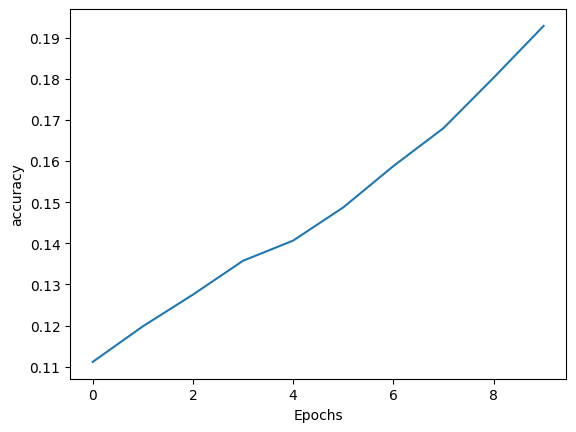

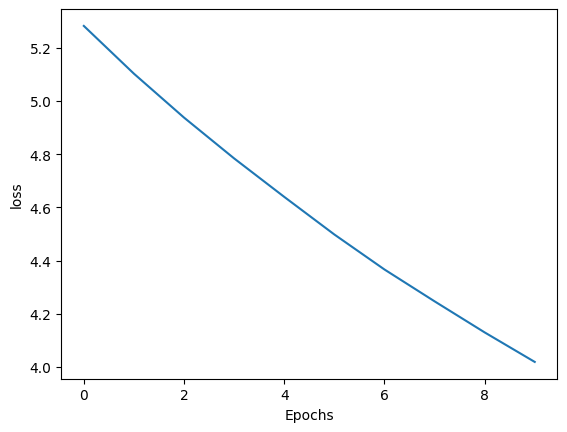

In [ ]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

### Analysis

Having used the keras tuner to tune our models, we arrived at an optimal model.

Analysising the Loss-Accuracy Curve, we observe the inverse relationship betweent the loss and accuracy values i.e progessive decrease in the loss values for each epoch results in increased accuracy values for the validation dataset. This supports the case for the best model.

# 4. Text Generation

In this section we will generate text with our trained model. The main task of the model is to predict the next word in a given sequence (of text). To predict sentences, we predict the next word for a given sequence and repeat the process.

In [ ]:
def text_generator(seed_text, model, tokenizer, num_words=50, max_seq_len=max_seq_length):
    assert len(seed_text) > 0, 'Error: seed_text is required'
    assert num_words > 0, 'Error: num_words is required'

    generated_text = seed_text

    # Loop for generating new words
    for _ in range(num_words):
        # Convert seed text to sequence and pad
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')

        # Get model prediction
        predicted_probs = model.predict(token_list, verbose=0)[0]

        # Sample from the probability distribution
        # (You might want to experiment with different sampling techniques, like temperature-based sampling)
        predicted_index = np.random.choice(len(predicted_probs), p=predicted_probs)

        # Convert index back to word
        output_word = tokenizer.index_word[predicted_index]

        # Append the word to generated text
        generated_text += " " + output_word

    return generated_text

In [ ]:
seed_text = "Shall I compare thee to a summer's day?"
# Generate 50 words
generated_text = text_generator(seed_text, best_model, tokenizer)
print(generated_text)

Shall I compare thee to a summer's day? of saying what is so applaud not full of me i have we run 'hum or arm out of youth the serving men 's hope make little prisoner have so wan in to the lady to disdain with clarence come harry hast i am it out of westmoreland then time


In [ ]:
seed_text = "Life"
# Generate 10 words
num_words = 10
generated_text = text_generator(seed_text, best_model, tokenizer, num_words)
print(generated_text)

Life at faith i day she should not got to sweeten


# 5. Conclusion

In this project, we trained a RNN model, using a corpus of Shakespear's plays, to generate text that mirrors Shakespear's unique vocabulary, syntax, and poetic patterns. We used keras tuner, to optimize our model resulting in getting the best model possible for our compute resource available. The loss-accuracy curve clearly supports the case best model, with the loss decreasing while accuracy increases after each epoch.

### Future Improvement

Given the limited compute resource available, we had to limit the chunk of this huge dataset to fit it on the RAM. This inevitable affects the level of accuracy of the model. However, in environments where compute resource is a limitation we could train with richer datasets and better model training and fitting.

